In [53]:
%load_ext autoreload
%autoreload 2
import os
if 'Notebooks' in os.getcwd():
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    os.chdir(project_root)
import tensorflow as tf
from Modules.ModelModule import Model, DataPreparation
import numpy as np
from Modules.GradCamTest import GradCAM
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import keras
from Modules.GradCam import GradCam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = Model.example_model()
model.load_weights('model.h5')

e:\OneDrive\Pulpit\BSc-thesis\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
model.get_layer(index = 1).get_weights()

[]

In [73]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,976,897 (22.80 MB)

 Trainable params: 5,976,897 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
image = DataPreparation.single_photo_preparation(r'data\train\train\Normal\9099440R.png')

In [12]:
image = tf.reshape(image, [1, 224, 224, 1])

In [13]:
image.shape

TensorShape([1, 224, 224, 1])

In [66]:
preds = Model.predict(model,image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [67]:
model(tf.keras.Input((224, 224, 1)))

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_57>

In [68]:
preds

ValueError: Only callable can be used as callback

In [32]:
i = preds[1][0][0]

In [33]:
i

0

In [58]:
icam = GradCAM(model, i, 'conv2d_3')

In [59]:
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread(r'data\train\train\Normal\9099440R.png')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

AttributeError: The layer sequential_1 has never been called and thus has no defined output.

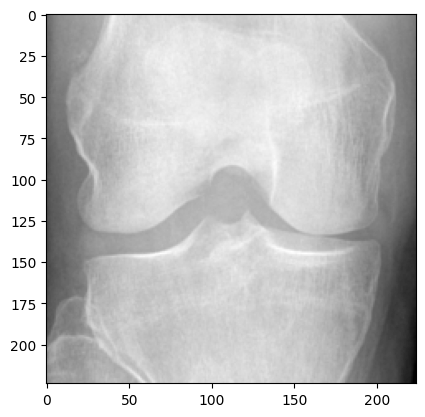

(1, 224, 224, 1)


In [46]:
image = cv2.imread(r'data\train\train\Normal\9458093R.png', 0)       # ATTENTION 
image = cv2.resize(image, (224, 224))

# checking how it looks 
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=-1)     # from 84 x 84 to 84 x 84 x 1 
image = tf.divide(image, 255)              # normalize
image = tf.reshape(image, [1, 224, 224, 1])  # reshape to add batch dimension

print(image.shape)

In [52]:
img = DataPreparation.single_photo_preparation(r'data\Valid\Valid\Osteoarthritis\9011661L.png')[0]
x = np.expand_dims(np.array(img.tolist(), dtype=np.float32), axis=0)

preds = Model.predict(model, x)
predicted_class = preds[1][0][0]
preds = preds[0]
model(tf.keras.Input((224, 224, 1)))

# Get the output tensor of the last convolutional layer
last_conv_layer = model.get_layer('conv2d_1')

# Create a model that maps the input image to the activations of the last conv layer as well as the output predictions
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.get_layer(index=-1).output])

# Compute the gradient of the top predicted class with respect to the output feature map of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)[0]

# Compute the CAM
cam = np.mean(conv_outputs[0], axis=-1)
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = cam / cam.max()

# Generate heatmap overlay
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


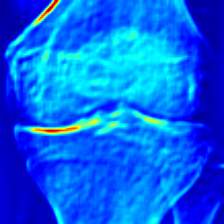

In [47]:
keras.utils.array_to_img(heatmap)

In [48]:
cam

array([[0.05019499, 0.04474942, 0.03322386, ..., 0.04292447, 0.046083  ,
        0.04757532],
       [0.04776491, 0.04268091, 0.0319206 , ..., 0.0432241 , 0.04657502,
        0.04815825],
       [0.04262164, 0.03830289, 0.02916226, ..., 0.04385828, 0.04761639,
        0.04939201],
       ...,
       [0.0813032 , 0.08174536, 0.08268118, ..., 0.05932691, 0.05682151,
        0.05563777],
       [0.0813032 , 0.08176159, 0.08273178, ..., 0.05796033, 0.05348483,
        0.05137026],
       [0.0813032 , 0.08176927, 0.08275568, ..., 0.05731465, 0.05190833,
        0.04935397]], dtype=float32)

In [31]:
conv_outputs

<tf.Tensor: shape=(1, 109, 109, 32), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.09886998, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.11445992, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.10127242, 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.04019211, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.02571451, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.02523442, 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.09432349, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.1000355 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.09430899, 0.        ],
         ...,
         [0.        , 0.     

In [20]:
x

array([[[[0.45490196],
         [0.44705883],
         [0.4509804 ],
         ...,
         [0.48235294],
         [0.49019608],
         [0.47843137]],

        [[0.45490196],
         [0.44313726],
         [0.44313726],
         ...,
         [0.48235294],
         [0.49411765],
         [0.49019608]],

        [[0.4392157 ],
         [0.43529412],
         [0.43137255],
         ...,
         [0.4862745 ],
         [0.4745098 ],
         [0.4862745 ]],

        ...,

        [[0.43529412],
         [0.43137255],
         [0.44705883],
         ...,
         [0.29411766],
         [0.29803923],
         [0.29803923]],

        [[0.43137255],
         [0.43137255],
         [0.44705883],
         ...,
         [0.3019608 ],
         [0.29411766],
         [0.3019608 ]],

        [[0.42745098],
         [0.41960785],
         [0.44705883],
         ...,
         [0.29411766],
         [0.28627452],
         [0.29803923]]]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


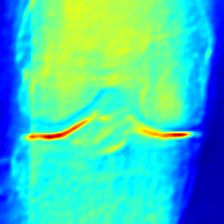

In [69]:
img = DataPreparation.single_photo_preparation(r'data\Valid\Valid\Osteoarthritis\9001104R.png')[0]
GradCam.create_and_overlap_gradcam(img, model)